# Covid-19 Data Analysis

The novel coronavirus is bringing societies worldwide to a halt and causing widespread health impacts. Still, there appears to be a paucity of information how the crisis is likely to unfold in the near future. Most news outlets only show aggreate numbers, color-coded world maps, or descriptive statistics of the current situation. 

In this workbook, I am taking a closer look at numbers and trends, and make some projections. All data are taken from the Johns Hopkins Covid-19 [dataset](https://github.com/CSSEGISandData/COVID-19) on GitHub. Each day, Johns Hopkins update the dataset with figures for the previous day. Numbers are pulled live when running the workbook. 

All projections are based on curve fitting on a per-country level. Thus, they extrapolate current trends. By nature, they can neither reflect the impact of recently enacted measures, which are expected to reduce infection rates, nor can they reflect new adverse developments. So please take everything with a grain of salt.

Please stay safe, look after your loved ones, and stay healthy. 

In [22]:
# Hide raw notebook code in exported HTML
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show) {
   $('div.input').hide();
 } else {
   $('div.input').show();
 }
 code_show = !code_show
} 
$(document).ready(code_toggle);
</script>
<form"><input type="button" value="Show/hide code" onclick="code_toggle()"></input></form>
''')

## Global Overview

As of March 20th end of day, there were 272k cases globally, and case growth continues unabated at 12% per day. 

11k people have died from this illness. At 14.5% daily, deaths are growing faster than new cases. 

From the data, recoveries appear to grow very slowly, at 3% daily. This may be due to the fact that many countries track new cases and deaths by legal obligation, but are not tracking recoveries as rigorously; particularly for mild cases. 

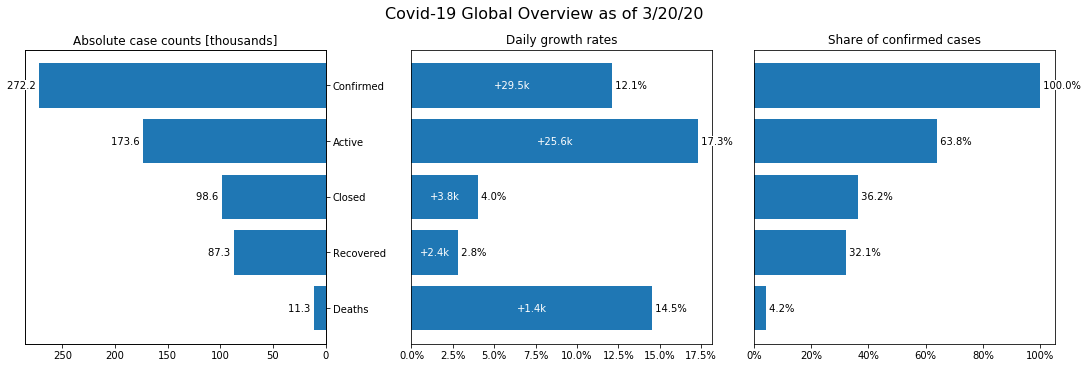

In [23]:
# Import required libraries
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy  as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates

import datetime as datetime
import operator
import sys

# Load data and group by country/region
def loadAndGroup(fileName, groupBy="Country/Region"):
    df=pd.read_csv(fileName)
    df=df.groupby(groupBy).sum()
    return df
    
# Load data
confd =loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
recovd=loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
deaths=loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
population=loadAndGroup('./population.csv','Country')
today =confd.columns[-1]

# Calculate new, previous and total as well as growth rate from time series
def newPrevTotalGrowth(df):
    df1        =df.loc[:, df.columns[-2]:]
    prev, total=df1.sum(axis=0)
    delta      =total-prev
    return delta, prev, total, delta/prev if prev!=0 else 0

# Calculate overall data sets for overview plots
confdNew,  confdPrev,  confdTotal,  confdGrowth =newPrevTotalGrowth(confd)
recovdNew, recovdPrev, recovdTotal, recovdGrowth=newPrevTotalGrowth(recovd)
deathsNew, deathsPrev, deathsTotal, deathsGrowth=newPrevTotalGrowth(deaths)

closedNew, closedPrev, closedTotal=recovdNew+deathsNew, recovdPrev+deathsPrev, recovdTotal+deathsTotal
closedGrowth=closedNew/closedPrev if closedPrev!=0 else 0
activeNew, activePrev, activeTotal=confdNew-closedNew, confdPrev-closedPrev, confdTotal-closedTotal
activeGrowth=activeNew/activePrev if activePrev!=0 else 0

labels=['Confirmed', 'Active', 'Closed', 'Recovered', 'Deaths']
valuesTotal=[confdTotal, activeTotal, closedTotal, recovdTotal, deathsTotal]
valuesNew=[confdNew, activeNew, closedNew, recovdNew, deathsNew]
valuesPrev=[confdPrev, activePrev, closedPrev, recovdPrev, deathsPrev]
valuesPerc=[1, activeTotal/confdTotal, closedTotal/confdTotal, recovdTotal/confdTotal, deathsTotal/confdTotal]
valuesGrowth=[confdGrowth, activeGrowth, closedGrowth, recovdGrowth, deathsGrowth]

# Prepare overview plot
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax=plt.subplots(nrows=1, ncols=3, constrained_layout=True)
fig.suptitle('Covid-19 Global Overview as of %s' % today, fontsize="16")

@plticker.FuncFormatter
def thousandsFormatter(x, pos):
    return "%.0f" % (x/1000)

# Left side: case counts
ax[0].set_title('Absolute case counts [thousands]')
ax[0].get_yaxis().set_visible(False)
ax2 = ax[0].twinx()
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.xaxis.set_major_formatter(thousandsFormatter)
ax2.barh(labels, valuesTotal)
for i, v in enumerate(valuesTotal):
    ax2.text(v, i, "%.1f " % (v/1000), ha='right', va='center', color='k', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'), backgroundcolor='w')

# Middle: Growth rates
ax[1].set_title('Daily growth rates')
ax[1].invert_yaxis()
ax[1].get_yaxis().set_visible(False)
ax[1].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[1].barh(labels, valuesGrowth)
for i, v in enumerate(zip(valuesGrowth, valuesNew)):
    ax[1].text(v[0]/2, i, "%+.1fk" % (v[1]/1000), ha='center', va='center', color='w')
for i, v in enumerate(valuesGrowth):
    ax[1].text(v, i, " %.1f%%" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'), backgroundcolor='w')
    
# Middle: Percentages
ax[2].set_title('Share of confirmed cases')
ax[2].invert_yaxis()
ax[2].get_yaxis().set_visible(False)
ax[2].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[2].barh(labels, valuesPerc)
for i, v in enumerate(valuesPerc):
    ax[2].text(v, i, " %.1f%%" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'), backgroundcolor='w')
        


## Global Time Series

On a global level, exponential growth appears to continue unabated. The first exponential growth wave in China plateaued in mid-February. Since then, the global spread of the disease has launched a second exponential growth wave of significantly higher magnitude. 

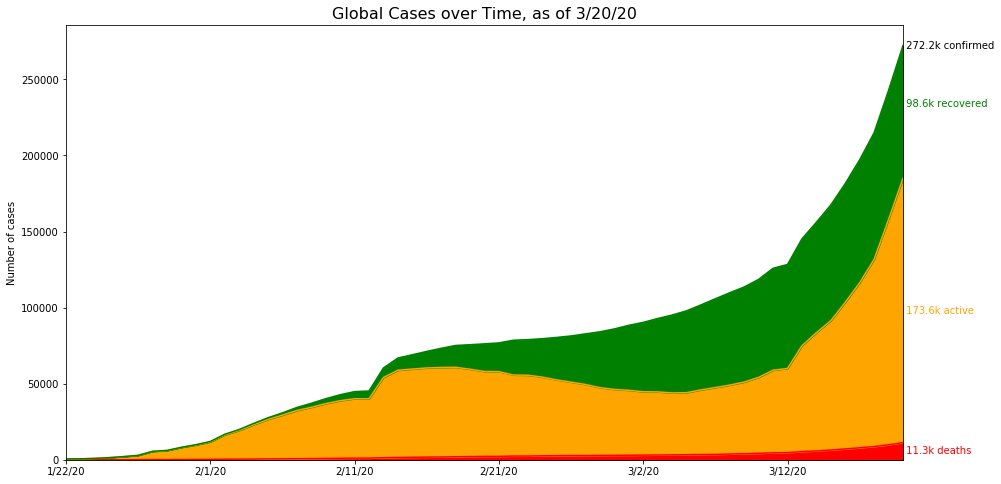

In [24]:
# Aggregate time series data on global level
globalConfd=confd.loc[:, confd.columns[2]:].sum(axis=0)
globalRecovd=recovd.loc[:, confd.columns[2]:].sum(axis=0)
globalDeaths=deaths.loc[:, confd.columns[2]:].sum(axis=0)
globalClosed=globalRecovd+globalDeaths
globalActive=globalConfd-globalClosed
globalDF=pd.DataFrame({
    'Deaths':globalDeaths, 
    'Active':globalActive,
    'Recovered':globalRecovd
})

# Prepare stacked area plot
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
colors=['r', 'orange', 'g']
globalDF.plot(ax=ax, kind='area', stacked=True, color=colors)
ax.set_title("Global Cases over Time, as of %s" % today, fontsize=16)
ax.set_ylabel("Number of cases")
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(reversed(handles), reversed(labels), loc='upper left')
ax.get_legend().remove()

# Plot and label the values
xPos=len(globalConfd.index)-1
x=globalConfd.index[xPos]
c, r, d, a, cl=globalConfd[x], globalRecovd[x], globalDeaths[x], globalActive[x], globalClosed[x]
ax.text(xPos, d/2, " %.1fk deaths" % (d/1000), ha='left', va='center', c='r')
ax.text(xPos, d+a/2, " %.1fk active" % (a/1000), ha='left', va='center', c='orange')
ax.text(xPos, d+a+cl/2, " %.1fk recovered" % (cl/1000), ha='left', va='center', c='g')
ax.text(xPos, c, " %.1fk confirmed" % (c/1000), ha='left', va='center', c='k')
plt.show()


There might be one ray of light: daily case growth on March 20 is on the same absolute level as on March 19th. This may be an early indication that social distancing measures are beginning to work. It might also be due to measurement noise; as e.g. the data of March 12th and 13th shows as well.  

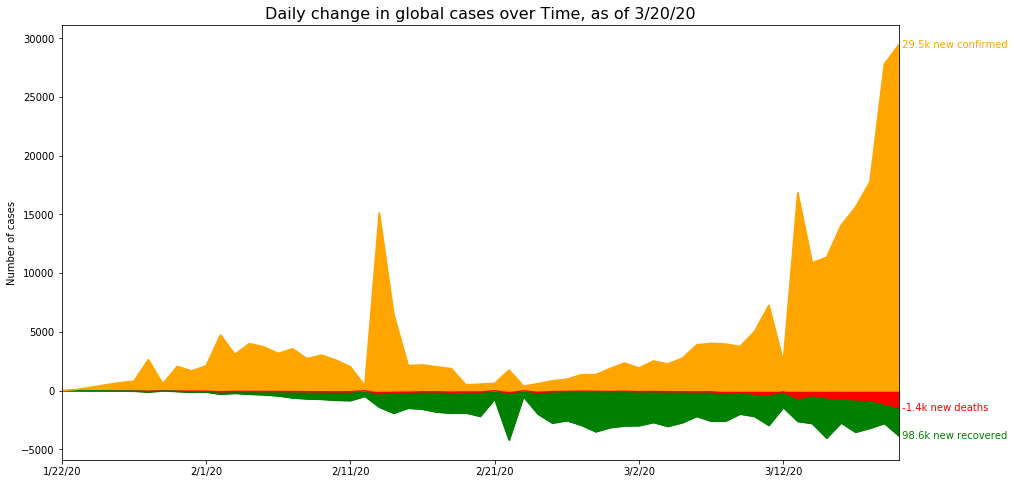

In [25]:
# Calculate daily deltas
globalConfdDelta=globalConfd.diff()
globalRecovdDelta=-globalRecovd.diff()
globalDeathsDelta=-globalDeaths.diff()
globalDFDelta=pd.DataFrame({
    'DeathsDelta':globalDeathsDelta, 
    'RecoveredDelta':globalRecovdDelta,
    'ConfirmedDelta':globalConfdDelta
})

# Prepare stacked area plot
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
colors=['r', 'g', 'orange' ]
globalDFDelta.plot(ax=ax, kind='area', stacked=True, color=colors)
ax.set_title("Daily change in global cases over Time, as of %s" % today, fontsize=16)
ax.set_ylabel("Number of cases")
ax.get_legend().remove()

# Plot and label the values
xPos=len(globalConfd.index)-1
x=globalConfd.index[xPos]
c, r, d=globalConfdDelta[x], globalRecovdDelta[x], globalDeathsDelta[x]
ax.text(xPos, d, " %.1fk new deaths" % (d/1000), ha='left', va='center', c='r')
ax.text(xPos, r+d, " %.1fk new recovered" % (cl/1000), ha='left', va='center', c='g')
ax.text(xPos, c, " %.1fk new confirmed" % (c/1000), ha='left', va='center', c='orange')
plt.show()

## Country Overview

China continues to have the most cases, however, growth rates have ground to a halt. For the first time, the number of cases in Italy, Spain and Germany exceeds Iran. The US is currently 6th most impacted, continuing to rise quickly. With case counts in Spain, Germany, Iran and US very close together, growth rates will be decisive for future development.

Among larger countries, the UK stands out with a 48% growth rate, followed by the US with a 40% growth rate. Both countries have attempted non-standard paths for disease containment and mitigation in early weeks, and only recently shifted towards standard measures. Germany and Switzerland are both growing at a 30% rate. Germany has taken a less aggressive stance on containment measures than e.g. Austria initially. Both Germany and Switzerland are also highly federal in nature. The bulk of European countries are growing in the 15-25% range

Also among larger countries, Italy and Switzerland have the highest number of cases per 100k population, a proxy for the highest infection risk from social interaction. Spain and Norway show the next highest case incidence per capita.

Case fatality rates, measured as number of deaths per number of confirmed cases, are highest in Italy with 8% and Iran with 7%, possibly due to overwhelmed health systems. China, Spain, France, the UK, the Netherlands and Japan are in the 3.5-5% range.  



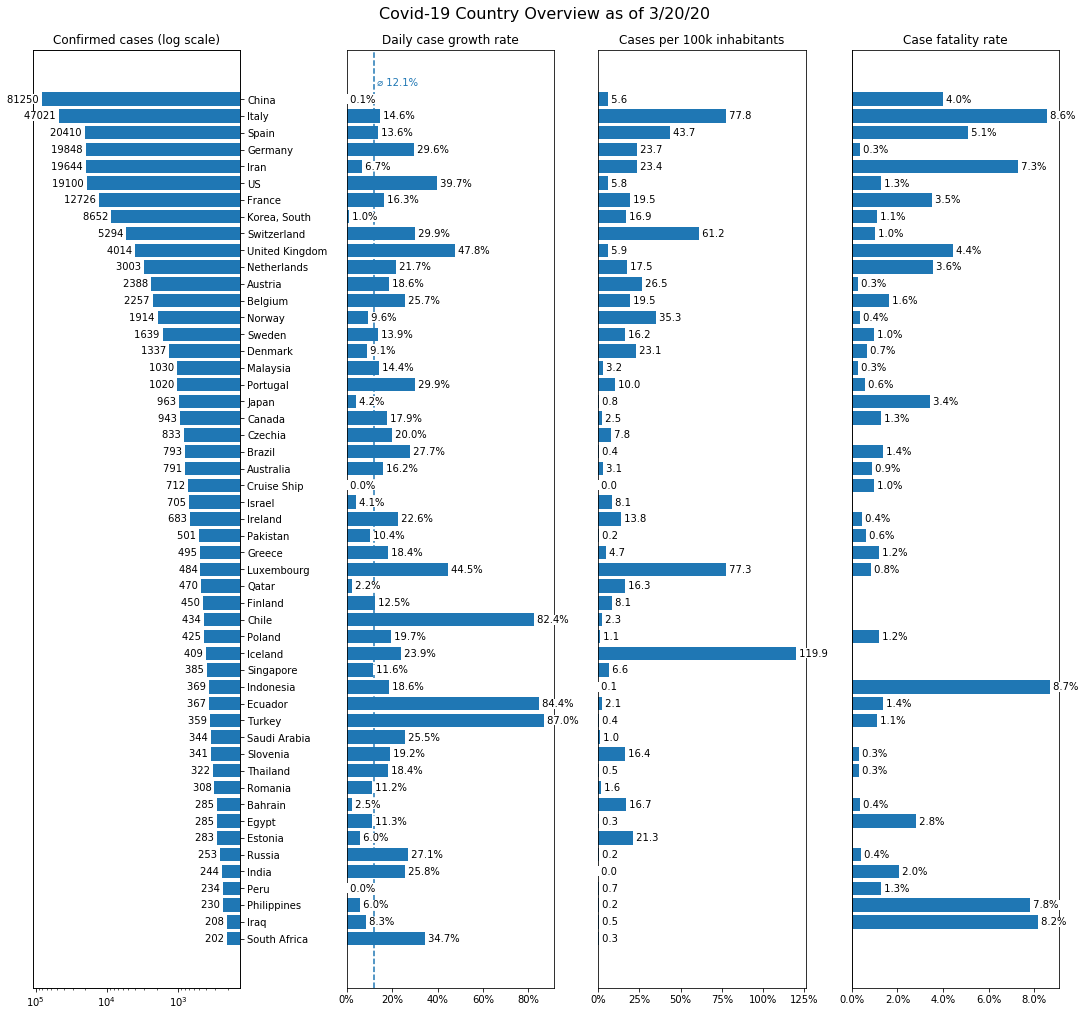

In [26]:
def lastGrowth(data):
    if len(data)>=2 and data[-2]>0:
        return data[-1]/data[-2]-1
    return 0    

# Calculate summary stats for all countries with number of cases above the threshold
threshold=200
validCountries=[]
for name in confd.index.values:
    conf1=confd.loc[name, confd.columns[2]:] # select row for given country, filter out lat/lon columns
    confv=conf1.to_numpy()
    if confv[-1]>=threshold:
        recovd1=recovd.loc[name, confd.columns[2]:]
        recovdv=recovd1.to_numpy()

        death1=deaths.loc[name, confd.columns[2]:]
        deathv=death1.to_numpy()

        summary={
            'Name':name,
            'Cases':confv[-1],
            'CaseGrowth':lastGrowth(confv),
            'Recovered':recovdv[-1],
            'RecoveredGrowth':lastGrowth(recovdv),
            'Deaths':deathv[-1],
            'DeathsGrowth':lastGrowth(deathv),
            'CFRTotal':deathv[-1]/confv[-1],
            'CFROutcome':deathv[-1]/(deathv[-1] + recovdv[-1]) if deathv[-1]+recovdv[-1]>0 else 0,
        }
        validCountries.append(summary)

# Prepare sorted stats        
validCountries.sort(key=lambda x: x['Cases'], reverse=True)

# Prepare data for plots
countryNames=[x['Name'] for x in validCountries]
countryCases=[x['Cases'] for x in validCountries]
countryGrowth=[x['CaseGrowth'] for x in validCountries]
countryCFRTotal=[x['CFRTotal'] for x in validCountries]
countryCFROutcome=[x['CFROutcome'] for x in validCountries]
countryPop1000=[population.loc[x]['PopulationInThousands'] for x in countryNames]
countryCasesPerPop1000=[cases/pop if pop!=0 else 0 for cases, pop in zip(countryCases, countryPop1000)]

# Prepare overview plot
plt.rcParams['figure.figsize'] = [15, 14]
fig, ax=plt.subplots(nrows=1, ncols=4, constrained_layout=True)
fig.suptitle('Covid-19 Country Overview as of %s' % today, fontsize="16")

# Left hand side: Plot lastest confirmed cases by country
ax[0].set_xscale('log')
ax[0].set_title('Confirmed cases (log scale)')
ax[0].get_yaxis().set_visible(False)
ax2 = ax[0].twinx()
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.barh(countryNames, countryCases)
for i, v in enumerate(countryCases):
    ax2.text(v, i, "%d " % v, ha='right', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Middle left: Plot latest growth rate by country
ax[1].set_title('Daily case growth rate')
ax[1].invert_yaxis()
ax[1].get_yaxis().set_visible(False)
ax[1].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[1].barh(countryNames, countryGrowth)
for i, v in enumerate(countryGrowth):
    ax[1].text(v, i, " %.1f%%" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Middle right: Plot cases per 1000 population
ax[2].set_title('Cases per 100k inhabitants')
ax[2].invert_yaxis()
ax[2].get_yaxis().set_visible(False)
ax[2].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[2].barh(countryNames, countryCasesPerPop1000)
for i, v in enumerate(countryCasesPerPop1000):
    ax[2].text(v, i, " %.1f" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

line =ax[1].axvline(x=confdGrowth, ymin=0, ymax=len(countryNames), ls="--")
ax[1].text(confdGrowth, -1, " \u2300 %.1f%%" % (confdGrowth*100), ha='left', va='center', color=line.get_color())

# Right: Plot CFR by country
ax[3].set_title('Case fatality rate')
ax[3].invert_yaxis()
ax[3].get_yaxis().set_visible(False)
ax[3].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
#ax[3].set_xlim(-0.2, 1.2)
#ax[3].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[3].axvline(x=0, ymin=0, ymax=len(countryNames), color='k', ls='-', lw='.8')
#ax[3].barh(countryNames, [x-y for (x,y) in zip(countryCFROutcome, countryCFRTotal)], left=countryCFRTotal)
ax[3].barh(countryNames, countryCFRTotal)
#for i, v in enumerate(countryCFROutcome):
#    ax[3].text(v, i, " %.1f%%" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
for i, v in enumerate(countryCFRTotal):
    if v!=0:
        ax[3].text(v, i, " %.1f%% " % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
#        ax[3].text(v, i, " %.1f%% " % (v*100), ha='right', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

plt.show()

Case fatality rate (CFR) is calculated as deaths/total confirmed cases. This is likely to be an understatement of the true value, as the outcome of currently active cases is still open. Alternative CFR measures like deaths/(deaths+recovered) lead to outlier results for many countries, as  recovery appears to take longer and data capture about recovery tends to be less strict than about deaths. I have therefore removed that indicator.

## Growth of Confirmed Cases

The chart shows the growth of confirmed cases by country. To developments more comparable across countries, each country curve is shifted in time so that day 0 corresponds to the moment when that country exceeds a threshold number of confirmed cases (here=200). 

From reported numbers, containment and mitigation appear to be most effective in China, South Korea and Japan. Most  countries are following the trajectory of Italy. 

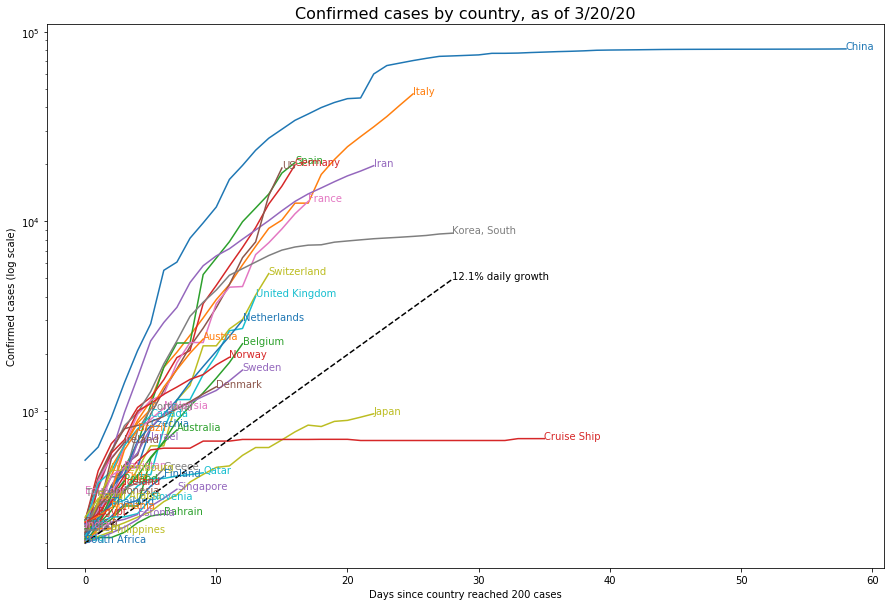

In [27]:
# Retrieve data for one country from the data frame
def getData(df, name):
    df1   =df.loc[name, df.columns[2]:]
    days  =df1.index.values
    days  =[datetime.datetime.strptime(d,"%m/%d/%y").date() for d in days]
    daynr =range(1, len(days)+1)
    values=df1.to_numpy()
    return days, daynr, values

# Crop away starting values < n from the arrays
def startAtN(values, n):
    while(len(values)>0 and values[0]<n):
        values=values[1:]
    return values

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

ax.set_title("Confirmed cases by country, as of %s" % today, fontsize=16)
ax.set_xlabel("Days since country reached %s cases" % threshold)
ax.set_ylabel("Confirmed cases (log scale)")
ax.set_yscale('log')

# Plot individual country curves
maxLen=0
for i, cty in enumerate(validCountries, start=0):
    name=cty['Name']
    days, daynr, values=getData(confd, name)
    shiftedValues=startAtN(values, threshold)
    if(len(shiftedValues)>maxLen):
        maxLen=len(shiftedValues)
    line, =ax.plot(range(0, len(shiftedValues)), shiftedValues)
    c=line.get_color()
    ax.text(len(shiftedValues)-1, shiftedValues[-1], name, color=c)

    
# Plot an exponential growth line with given start value and factor
def plotFactor(ax, start,factor,length):
    xs=range(0, length)
    ys=[start]
    while(len(ys)<length):
        ys.append(factor*ys[-1])

    line, =ax.plot(xs, ys,"--k")
    c=line.get_color()
    ax.text(xs[-1], ys[-1], "%.1f%% daily growth" % (factor*100-100), color=c)

# Plot the growth line
plotFactor(ax,threshold, 1+confdGrowth, maxLen//2)
   
plt.show()


## Most Impacted Country Details

Three charts per country: confirmed cases, recovered cases and deaths. Black dots show the actual values from Hopkins. The smooth lines have been fitted to the data. The model tries to fit both an exponential function, which grows without bound, and a sigmoid function, which flattens out again. It selects the curve with the lowest mean square error. 

Projections are for one week and should be taken with a grain of salt. The difference between exponential and sigmoid growth can be substantial over that time period. So, slight differences in measurement noise may lead to significantly different outcomes.

If ongoing mitigations do not materially change the course of the disease, one week from now, the US is going to be the most impacted country, with upwards of 200k cases, followed by Germany in the mid-80s, and Italy in the mid-70s. 

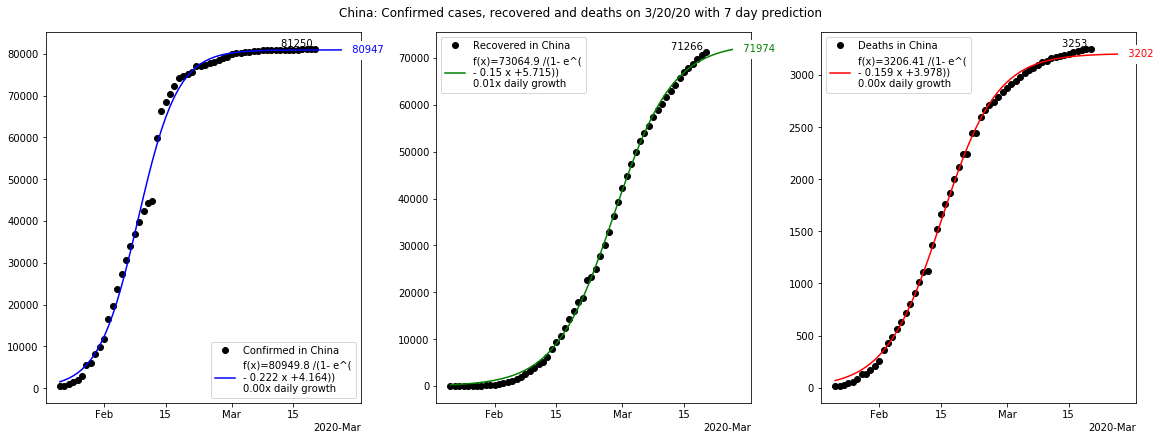

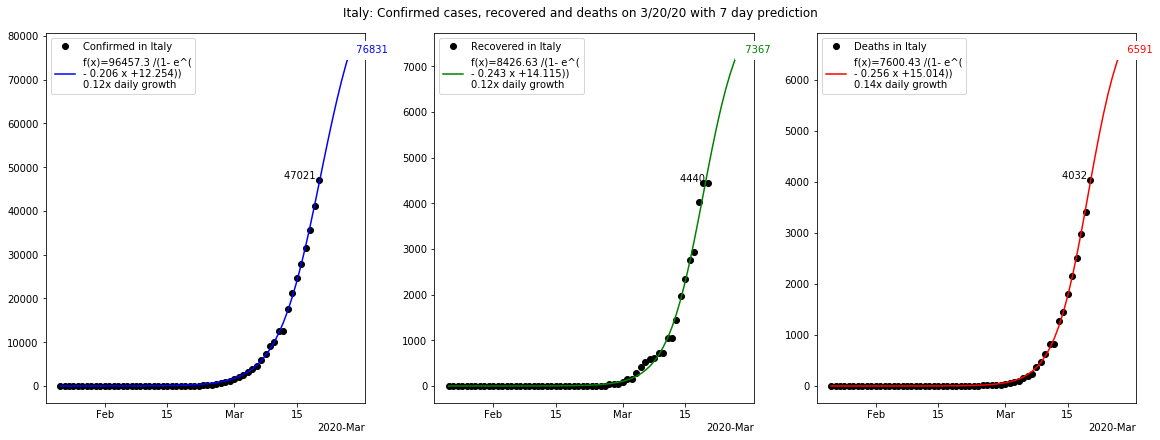

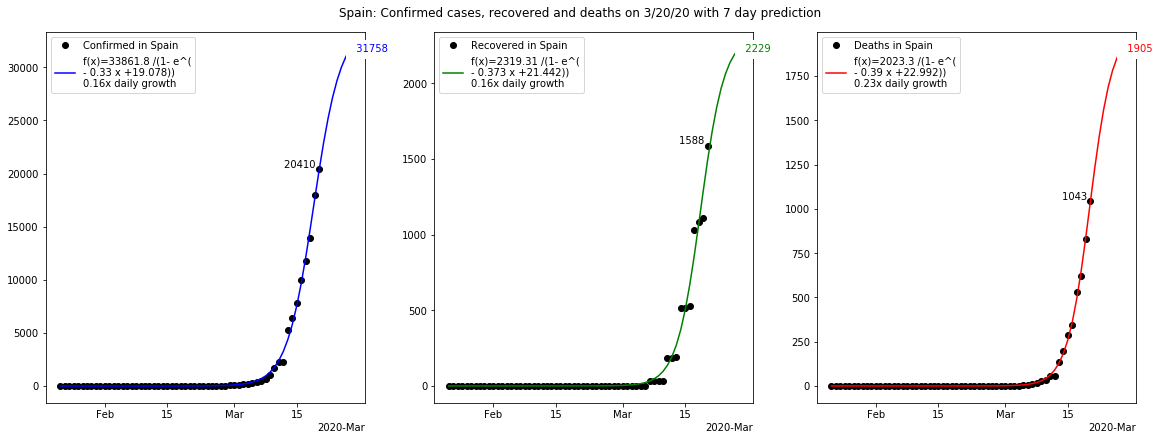

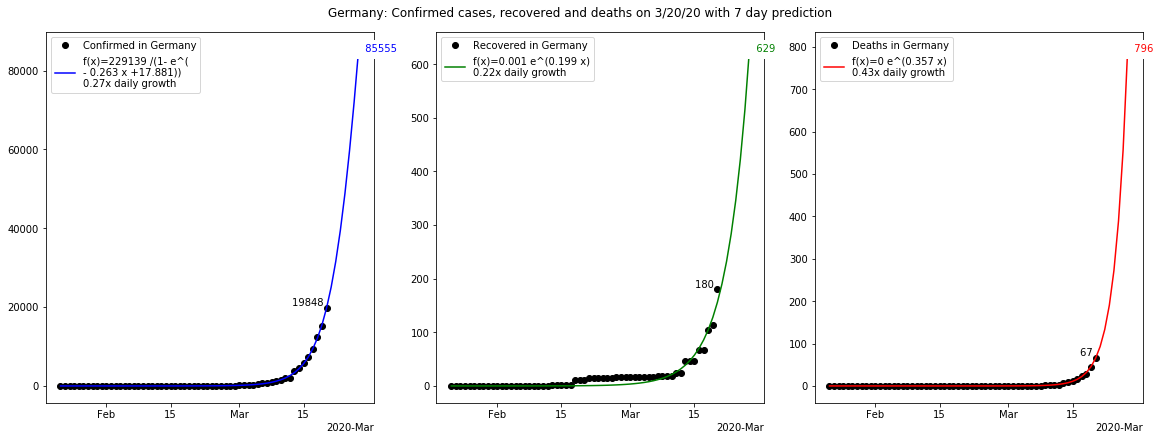

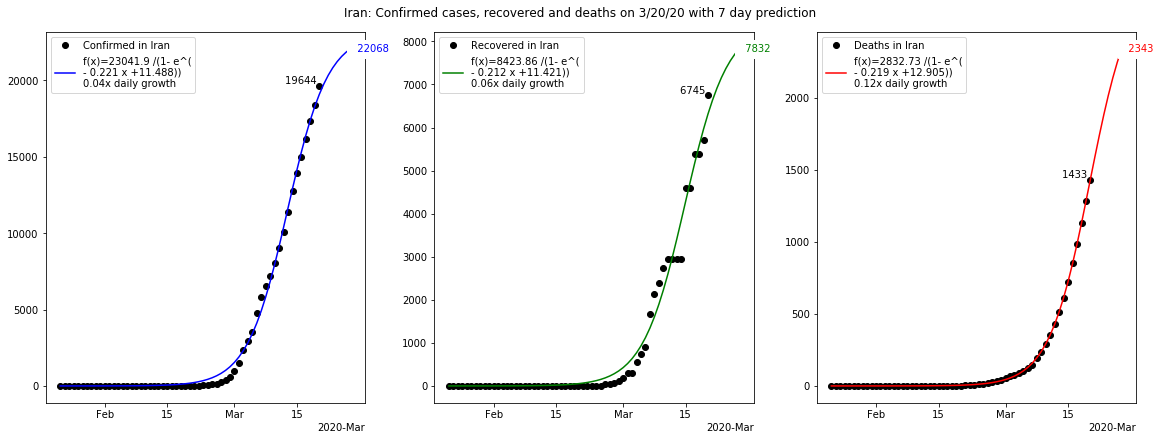

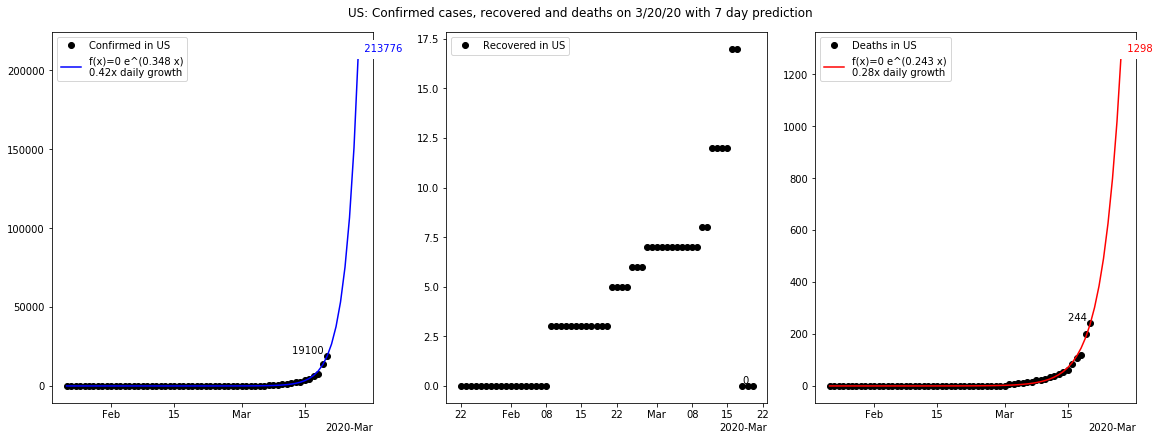

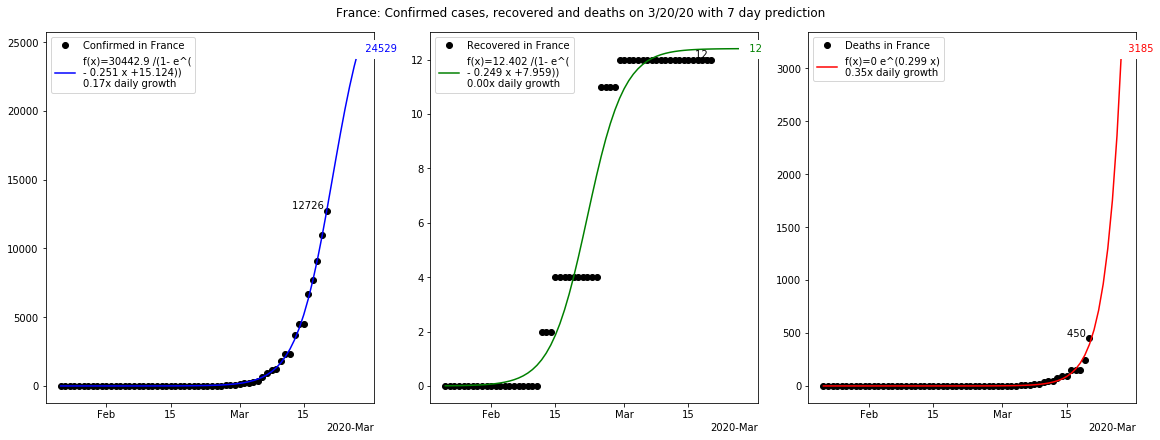

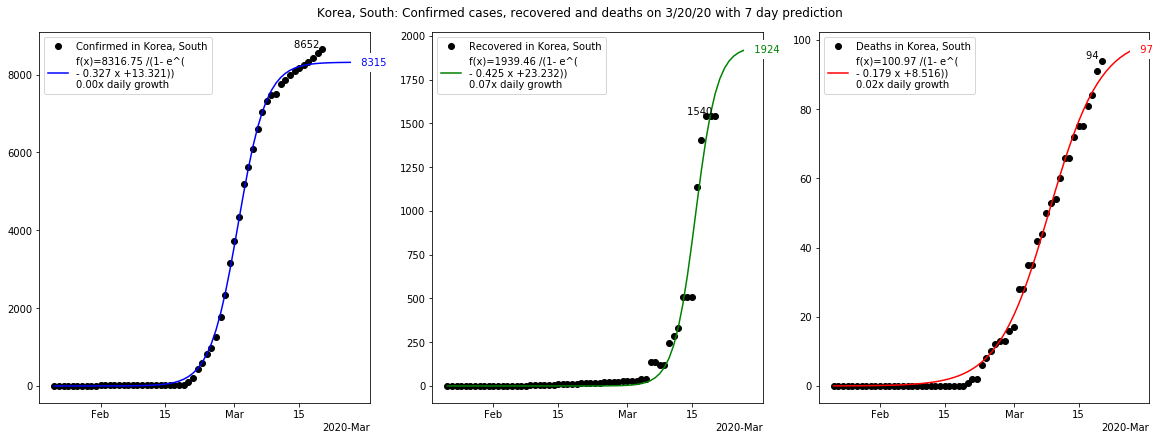

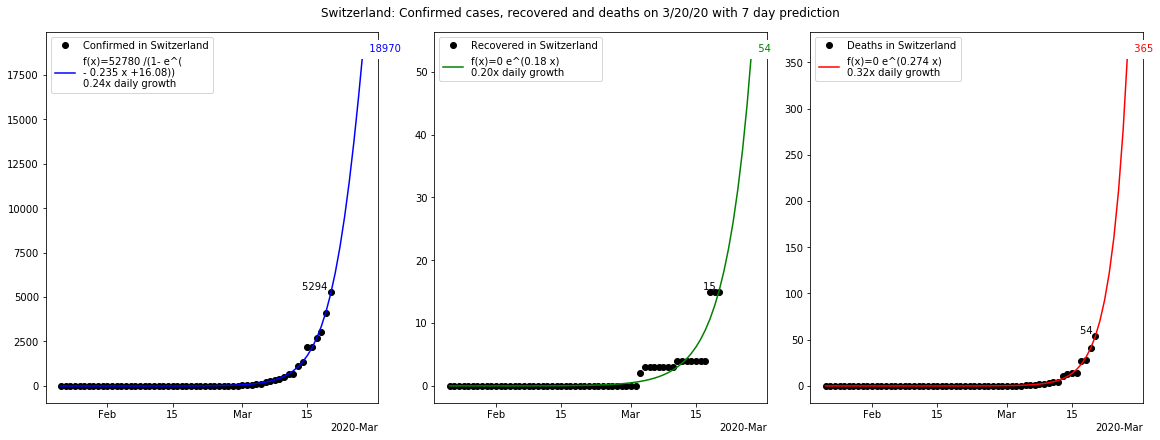

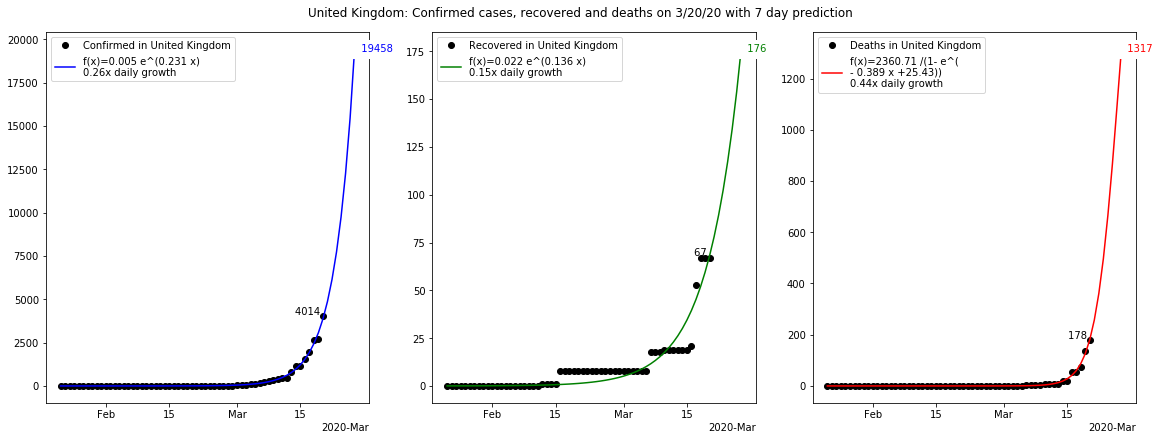

In [28]:
# Exponential model for fitting
def fitExp(x, a, b):
    return a*np.exp(b*x)

# Sigmoid model for fitting
def fitSig(x, a, b, c):
    return a/(1.0+np.exp(-b*x + c))

def s3(x):
    return np.around(x,decimals=3)

def cropDuplicateLeadingZeros(days, daynr, values):
    while(len(days)>1 and values[1]<=0):
        days, daynr, values=days[1:], daynr[1:], values[1:]
    return days, daynr, values

def extendTime(days, daynr, extraDays):
    for i in range(0, extraDays):
        days=np.append(days,days[-1]+datetime.timedelta(days=1))
        daynr=np.append(daynr, daynr[-1]+1)
    return days, daynr

# Fit given curve to the given data
def fitCurve(cropDaynr, cropValues, fitFunc, p0, eqFormatter):
    try:
        # fit curve
        popt, pcov=curve_fit(fitFunc, cropDaynr, cropValues, p0)
    
        # estimate error
        cropProj=fitFunc(cropDaynr, *popt)   # estimate error
        sqdiff=np.sum((cropValues-cropProj)**2)
        
        # generate label for chart
        equation=eqFormatter(popt) 
        if(len(cropProj)>=2 and cropProj[len(cropProj)-2]!=0):
            growthRate=cropProj[len(cropProj)-1]/cropProj[len(cropProj)-2]-1
        else:
            growthRate=0
        fitLabel="%s\n%.2fx daily growth" % (equation, growthRate)
        return popt, pcov, sqdiff, fitLabel
            
    except (RuntimeError, TypeError) as e:
        return [], [], sys.float_info.max, ""
        
# Fit curves to the data, pick best fit, plot on the given axes
def fitAndPlot(days, daynr, values, ax, label, name, fitDrawingStyle, extDays):
    # Plot raw data and label last data point 
    ax.plot(days, values, 'ko', label="%s in %s" % (label, name))
    ax.text(days[-1], values[-1], "%.0f " % values[-1], color='k', horizontalalignment="right", verticalalignment="bottom")

    if values[-1]>1:
        # Fit on reduced dataset without leading zeros
        cropDays, cropDaynr, cropValues=cropDuplicateLeadingZeros(days, daynr, values)
        extDays, extDaynr=extendTime(days, np.array(daynr), extDays)
        fittings=[
            [ fitExp, [0.1, 0.1],            lambda popt: "f(x)=%g e^(%g x)" % (s3(popt[0]), s3(popt[1])) ],
            [ fitSig, [values[-1], 0.1, 10], lambda popt: "f(x)=%g /(1- e^(\n- %g x %+g))" % (s3(popt[0]), s3(popt[1]), s3(popt[2])) ]
        ]

        # Perform and evaluate curve fits
        bestSqdiff, bestFitFunc, bestPopt, bestFitLabel=sys.float_info.max, [], [], ""
        for fitFunc, p0, eqFormatter in fittings:
            popt, pcov, sqdiff, fitLabel=fitCurve(cropDaynr, cropValues, fitFunc, p0, eqFormatter)
            if sqdiff<bestSqdiff:
                bestSqdiff, bestFitFunc, bestPopt, bestFitLabel=sqdiff, fitFunc, popt, fitLabel

        # Plot the best fit, if it exists
        if bestSqdiff<sys.float_info.max:
            extProj=bestFitFunc(extDaynr, *bestPopt)
            line, =ax.plot(extDays, extProj,  fitDrawingStyle, label=bestFitLabel)
            ax.text(extDays[-1], extProj[-1], "  %.0f" % extProj[-1], color=line.get_color(), backgroundcolor='w', horizontalalignment="left", verticalalignment="center" )

    # Finish up the formatting
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.legend()

# Fit curve and plot for the top K valid countries and given number of extension days
topK=10
extDays=7
for i, cty in enumerate(validCountries[0:topK], start=0):
    name=cty['Name']

    # Prepare plot area
    plt.rcParams['figure.figsize'] = [16, 6]
    fig, axs=plt.subplots(nrows=1, ncols=3, constrained_layout=True)
    plt.suptitle('%s: Confirmed cases, recovered and deaths on %s with %d day prediction' % (name, today, extDays))

    # Select and plot data for this country
    chartParams=[(confd, axs[0], "Confirmed", "b-"), (recovd, axs[1], "Recovered", "g-"), (deaths, axs[2], "Deaths", "r-")]
    for df, ax, legend, fitDrawingStyle in chartParams:
        days, daynr, values=getData(df, name)
        fitAndPlot(days, daynr, values, ax, legend, name, fitDrawingStyle, extDays)
    plt.show()

For questions and comments, please reach out to Markus Noga.